# MSE 211 MDP Project

We can do the project here

In [1]:
from mdp import *
from solver import *

import matplotlib.pyplot as plt
import numpy as np

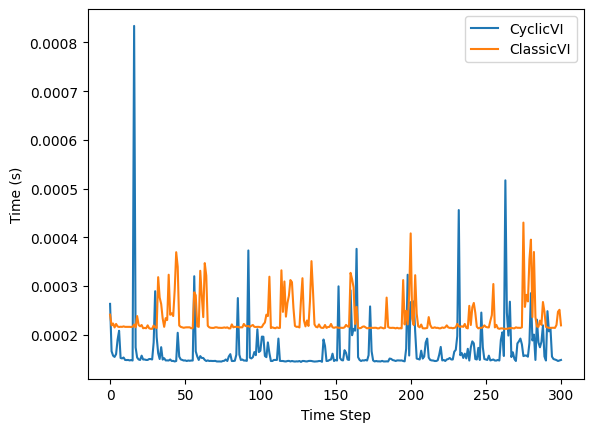

In [2]:
g = GridWorld(5)

iterators = [CyclicVI(), ClassicVI()]#[RandomVI(k=k) for k in range(1, 26, 5)]

for iterator in iterators:
    solver = Solver(iterator, g, 0.9)
    solver.solve(steps = 300)
    solver.plot_time()
    
plt.legend()
plt.show()


In [3]:
iterators = [CyclicVI(), ClassicVI(), RandomCyclicVI()] + [RandomVI(k=k) for k in [5,15,20]]

data = { iterator.name : {} for iterator in iterators }

for iterator in iterators:
    name = iterator.name
    solver = Solver(iterator, g, 0.9)
    measures = []
    for _ in range(50):
        solver.solve(steps=300)
        measures.append(solver.time_each_step)
    measures = np.array(measures)
    avg = measures.mean(axis=0)

    data[name]["avg_speed"] = avg
    data[name]["delta"] = solver.deltas

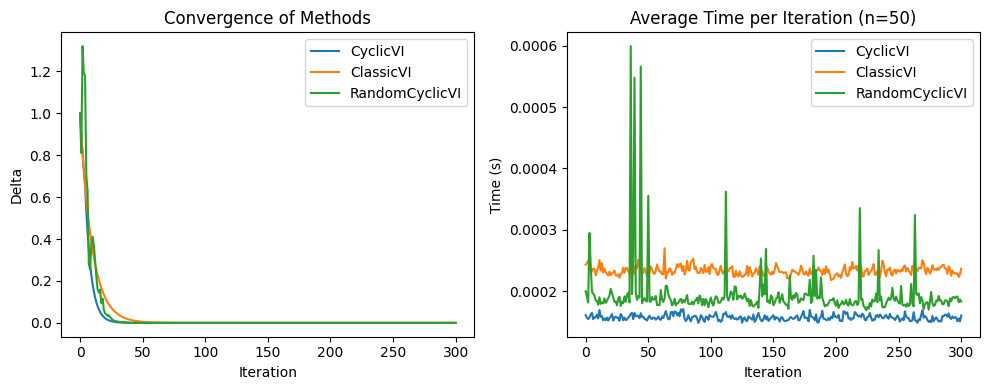

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Plot one iteration for convergence
ax = axs[0]
for name in data:
    if "k" not in name:
        ax.plot(data[name]["delta"], label=name)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Delta")
        ax.set_title("Convergence of Methods")

ax.legend()

# Plot deltas over time
ax = axs[1]
for name in data:
    if "k" not in name:
        ax.plot(data[name]["avg_speed"], label=name)
        ax.set_ylabel("Time (s)")
        ax.set_xlabel("Iteration")
        ax.set_title("Average Time per Iteration (n={})".format(50))

ax.legend()

plt.tight_layout()
plt.savefig("figs/classic_cyclic_randomcyclic.png")

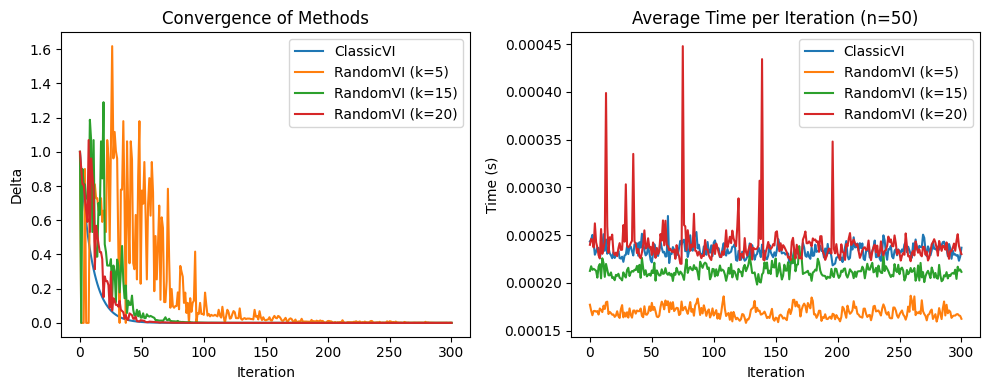

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Plot one iteration for convergence
ax = axs[0]
for name in data:
    if "Cyclic" not in name:
        ax.plot(data[name]["delta"], label=name)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Delta")
        ax.set_title("Convergence of Methods")

ax.legend()

# Plot deltas over time
ax = axs[1]
for name in data:
    if "Cyclic" not in name:
        ax.plot(data[name]["avg_speed"], label=name)
        ax.set_ylabel("Time (s)")
        ax.set_xlabel("Iteration")
        ax.set_title("Average Time per Iteration (n={})".format(50))

ax.legend()

plt.tight_layout()
# plt.savefig("figs/classic_random.png")

In [6]:
# Look only at the starting states, which are the ones where there is only
# one X
model = TicTacToe()
N = len(model.states)

iterators = [RandomVI(k=int(k)) for k in [N * 0.1, N * 0.5, N * 0.75]] + [ClassicVI(), CyclicVI(), RandomCyclicVI()] 
solvers = []

for iterator in iterators:
    solver = Solver(iterator, model, 0.9)
    solver.solve(steps=20)
    solvers.append(solver)



In [7]:
def display_start_state_board(ax, solver):

    name = solver.iterator.name
    solution = solver.solution
    solution_keys = list(solution.keys())
    
    def start_state(board):
        x_count = board.count("X")
        o_count = board.count("O")
        return x_count == 1 and o_count == 0
    
    # Get states for initial boards
    initial_boards = list(filter(start_state, solution_keys))
    
    initial_board_data = np.array([solution[board] for board in initial_boards]).reshape(3,3)
    
    cbarlabel="State Value"
    im = ax.imshow(initial_board_data, cmap="summer")
    
    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, "{:.3f}".format(initial_board_data[i, j]),
                           ha="center", va="center", color="black")
    
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    ax.set_title(name)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

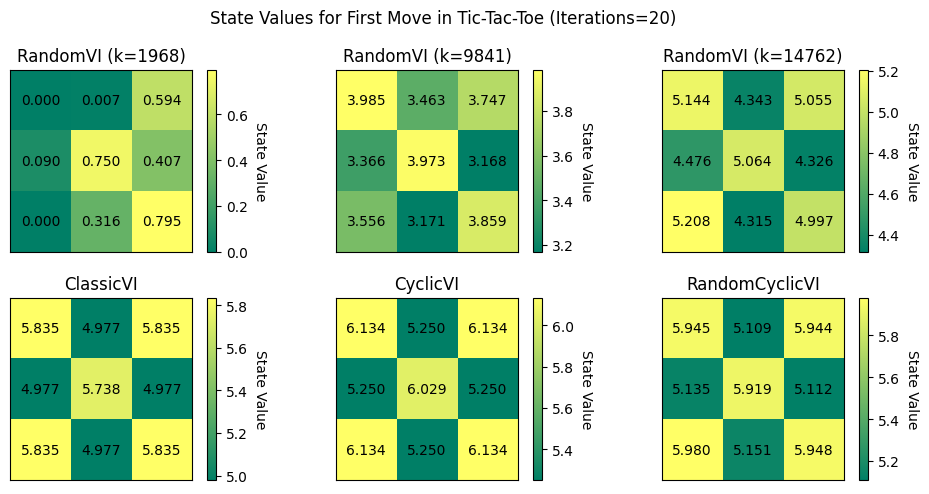

In [8]:
fig, axs = plt.subplots(2,3, figsize=(10,5))
for i, solver in enumerate(solvers):
    ax = axs.flatten()[i]
    display_start_state_board(ax, solver)

fig.suptitle("State Values for First Move in Tic-Tac-Toe (Iterations=20)")
plt.tight_layout()
plt.savefig("figs/tictactoe.png")